In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

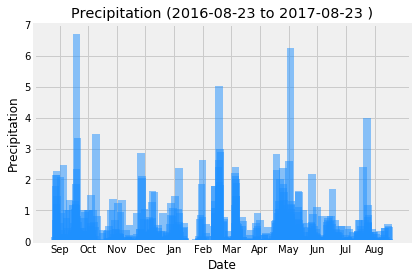

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date_1 = session.query(func.max(Measurement.date)).first()
# latest_date_1
latest_date = latest_date_1[0].split('-')
latest_date

# Calculate the date 1 year ago from the last data point in the database
past_date = dt.date(int(latest_date[0]), int(latest_date[1]),int(latest_date[2]))- dt.timedelta(days=365)
# past_date

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= past_date).\
                filter(Measurement.date <= latest_date_1[0]).\
                order_by(Measurement.date).all()
# precipitation

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(precipitation).set_index('date')
# df

# Use Pandas Plotting with Matplotlib to plot the data
# Use Pandas Plotting with Matplotlib to plot the data
plt.title("Precipitation (2016-08-23 to 2017-08-23 )")
plt.xlabel("Date")
plt.ylabel("Precipitation")

# Define months for x-ticks labels
months = ["Sep", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]

# Define X and Y values
y = df["prcp"].tolist()
x = np.arange(0, len(df.index.tolist()), 1)

# Define X-tick labels (months) and their positioning
total_month = len(y)
month_step_xticks = int((total_month / 12)*1.03)
plt.ylim = max(y) + 1
tick_locations = [x+55 for x in range(1, total_month, month_step_xticks)]

plt.bar(x, y, width=50, color="dodgerblue", alpha=0.5, align="edge")
plt.xticks(tick_locations, months)

plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()
# session.query(Station).all()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_count = func.count(Measurement.station)
session.query(Measurement.station, station_count).group_by(Measurement.station).order_by(station_count.desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_max_tobs = session.query(Measurement.station, func.max(Measurement.tobs)).all()
station_max_tobs

[('USC00519397', 87.0)]

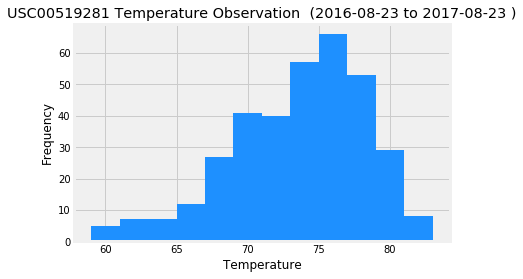

In [16]:
tobs = session.query(Measurement.tobs).\
                filter(Measurement.station == "USC00519281").\
                filter(Measurement.date >= past_date).all()
tobs

df_tobs = pd.DataFrame(tobs)
df_tobs

plt.title("USC00519281 Temperature Observation  (2016-08-23 to 2017-08-23 )")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

plt.hist(df_tobs["tobs"],bins = 12, color="dodgerblue")
# plt.xticks(tick_locations, months)

plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tmin, tavg, tmax = calc_temps((dt.date(2016,8,23)).strftime("%Y-%m-%d"), (dt.date(2017,8,23)).strftime("%Y-%m-%d"))[0]

print(tmin, tavg, tmax)


58.0 74.59058295964125 87.0


[Text(0, 0.5, 'Temperature'), Text(0.5, 1.0, 'Trip Avg Temp')]

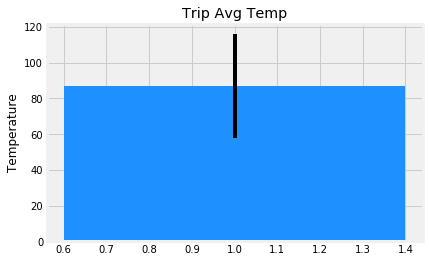

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
x = 1
bar = ax.bar(x, tmax, yerr=(tmax-tmin), color='dodgerblue')
ax.set(title="Trip Avg Temp", ylabel="Temperature")


In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#2016-08-23 to 2017-08-23
sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 147.81000000000006), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 70.03000000000003), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.510000000000026), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 38.01), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 33.239999999999995), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59)]


In [30]:

data = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= dt.date(2016,8,23)).\
        filter(Measurement.date <= dt.date(2017,8,23)).all()
jsonify(data)

NameError: name 'jsonify' is not defined

## Optional Challenge Assignment

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
